In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import datetime as dt

In [2]:
# Load the data
file_path = '../../../Dataset/DOGE-USD.csv'
df = pd.read_csv(file_path, parse_dates=True, index_col=0)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-01,0.006042,0.006320,0.005945,0.006215,0.006215,15518400
2018-03-02,0.006174,0.006232,0.005447,0.005482,0.005482,22498100
2018-03-03,0.005494,0.005756,0.005181,0.005301,0.005301,21545000
2018-03-04,0.005234,0.005502,0.005164,0.005502,0.005502,12133500
2018-03-05,0.005462,0.005535,0.005157,0.005218,0.005218,13627700


In [3]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    # df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    # df['MA200_low'] = df['Low'].rolling(window=200).min()
    # df['MA14_low'] = df['Low'].rolling(window=14).min()
    # df['MA200_high'] = df['High'].rolling(window=200).max()
    # df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    df['Bollinger_Middle'] = df['MA20'] 
    
    # Relative Strength Index (RSI)
    # df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    # Relative Strength Index (RSI) not using the K-ratio
    # df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)
    
    # 
    return df

               Close      MACD  Bollinger_Upper  Bollinger_Lower      MA26     EMA20
Date                                                                                
2018-10-02  0.005824  0.000241         0.006478         0.005382  0.005966  0.005739
2018-10-03  0.005704  0.000213         0.006358         0.005417  0.005981  0.005736
2018-10-04  0.005645  0.000183         0.006322         0.005400  0.005979  0.005727
2018-10-05  0.005669  0.000159         0.006282         0.005391  0.005973  0.005722
2018-10-06  0.005545  0.000129         0.006110         0.005464  0.005921  0.005705


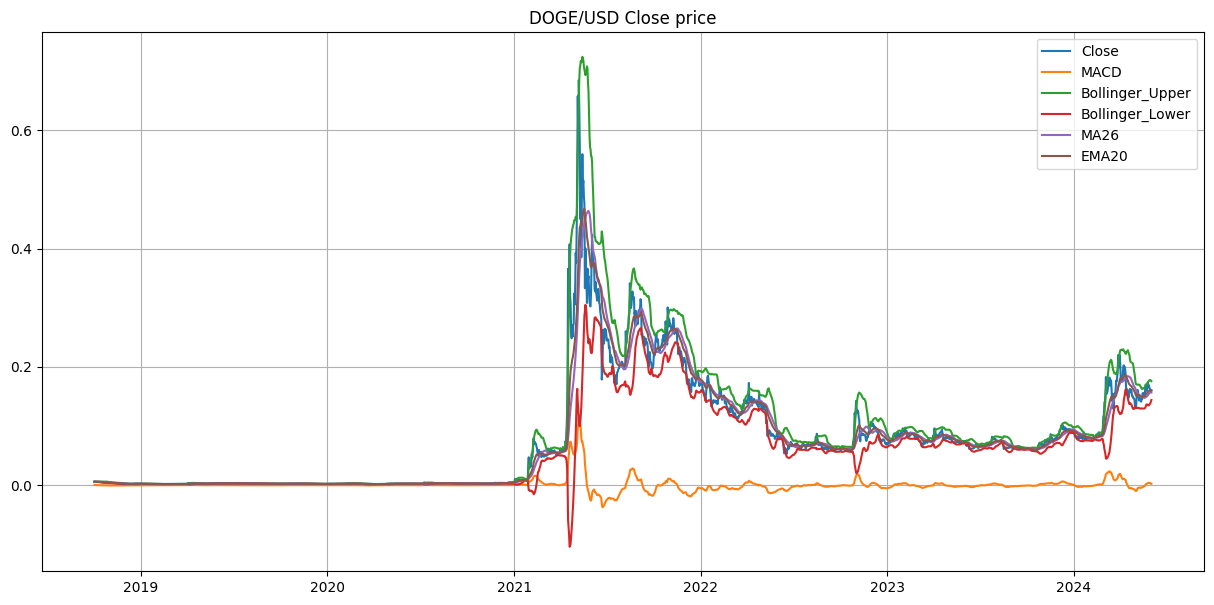

In [4]:
# List of considered Features
FEATURES = [
            # 'High',
            # 'Low',
            # 'Open',
            'Close',
            # 'Volume',
#             'Day',
#             'Month',
#             'Year',
            # 'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
            'MACD',
            # 'RSI',
            # 'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
            # 'MA100',            
#             'MA50',
            'MA26',
#             'MA14_low',
#             'MA14_high',
            # 'MA12',
            'EMA20',
            # 'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE',
            # 'MA20dSTD',
            # 'Close_Diff',
            # 'K-ratio'
           ]
# Create the dataset with features
df_features = createFeatures(df)

# Shift the timeframe by 10 month -> Start date is 2010-11-01
use_start_date = pd.to_datetime("2018-10-01")
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
df_filtered = df_features[FEATURES].copy()
# Filter the data to the list of FEATURES
df_filtered = df_filtered.dropna()
# Filter the data to the list of FEATURES
print(df_filtered.head().to_string())  
    

# Create the lineplot
plt.style.use('default')
plt.figure(figsize=(15, 7))
plt.plot(df_filtered)
plt.title('DOGE/USD Close price')
plt.grid()
plt.legend(df_filtered.columns)
plt.show()

In [5]:
# Training and Test dataset
test_size = 0.2
train_size = int(len(df_filtered) * (1 - test_size))
train, test = df_filtered.iloc[0:train_size], df_filtered.iloc[train_size:len(df_filtered)]

In [6]:
X_train = train.drop('Close', axis=1)
y_train = train['Close']

X_test = test.drop('Close', axis=1)
y_test = test['Close']


In [7]:
# XGBoost
# XGBoost Regressor
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train
        , y_train
        , eval_set=[(X_train, y_train), (X_test, y_test)]
        , early_stopping_rounds=50
       )

[0]	validation_0-rmse:0.07230	validation_1-rmse:0.03371
[1]	validation_0-rmse:0.05197	validation_1-rmse:0.02516
[2]	validation_0-rmse:0.03776	validation_1-rmse:0.02048
[3]	validation_0-rmse:0.02790	validation_1-rmse:0.01699
[4]	validation_0-rmse:0.02084	validation_1-rmse:0.01522
[5]	validation_0-rmse:0.01578	validation_1-rmse:0.01543
[6]	validation_0-rmse:0.01225	validation_1-rmse:0.01535
[7]	validation_0-rmse:0.00974	validation_1-rmse:0.01644
[8]	validation_0-rmse:0.00802	validation_1-rmse:0.01653
[9]	validation_0-rmse:0.00685	validation_1-rmse:0.01681
[10]	validation_0-rmse:0.00601	validation_1-rmse:0.01710
[11]	validation_0-rmse:0.00534	validation_1-rmse:0.01710
[12]	validation_0-rmse:0.00487	validation_1-rmse:0.01717
[13]	validation_0-rmse:0.00451	validation_1-rmse:0.01724
[14]	validation_0-rmse:0.00419	validation_1-rmse:0.01751
[15]	validation_0-rmse:0.00393	validation_1-rmse:0.01745
[16]	validation_0-rmse:0.00372	validation_1-rmse:0.01755
[17]	validation_0-rmse:0.00359	validation

C:\Users\lequo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-rmse:0.00206	validation_1-rmse:0.01849
[38]	validation_0-rmse:0.00203	validation_1-rmse:0.01851
[39]	validation_0-rmse:0.00198	validation_1-rmse:0.01851
[40]	validation_0-rmse:0.00195	validation_1-rmse:0.01851
[41]	validation_0-rmse:0.00190	validation_1-rmse:0.01869
[42]	validation_0-rmse:0.00187	validation_1-rmse:0.01873
[43]	validation_0-rmse:0.00181	validation_1-rmse:0.01874
[44]	validation_0-rmse:0.00178	validation_1-rmse:0.01876
[45]	validation_0-rmse:0.00174	validation_1-rmse:0.01876
[46]	validation_0-rmse:0.00171	validation_1-rmse:0.01874
[47]	validation_0-rmse:0.00167	validation_1-rmse:0.01875
[48]	validation_0-rmse:0.00166	validation_1-rmse:0.01875
[49]	validation_0-rmse:0.00164	validation_1-rmse:0.01875
[50]	validation_0-rmse:0.00161	validation_1-rmse:0.01879
[51]	validation_0-rmse:0.00158	validation_1-rmse:0.01879
[52]	validation_0-rmse:0.00156	validation_1-rmse:0.01880
[53]	validation_0-rmse:0.00154	validation_1-rmse:0.01893
[54]	validation_0-rmse:0.00152	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

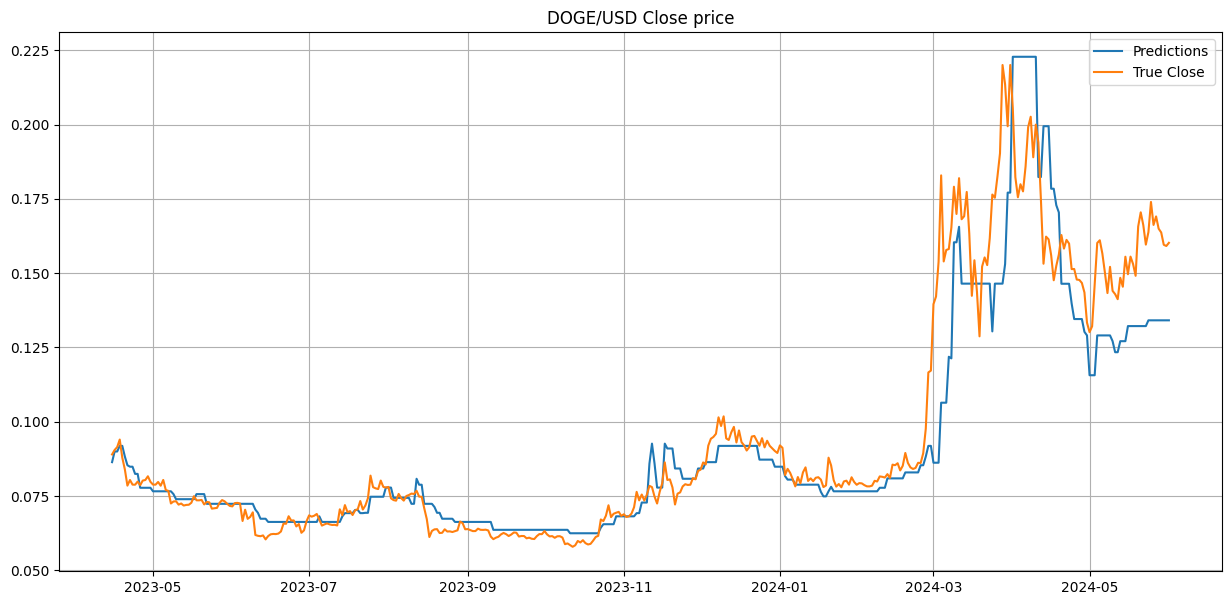

In [8]:
# Make predictions for validation and test sets
test_preds = reg.predict(X_test)

# plot the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test_preds, label='Predictions')
plt.plot(test.index, test['Close'], label='True Close')
plt.title('DOGE/USD Close price')
plt.grid()
plt.legend()
plt.show()

In [9]:
# Create function to forecast next x days
def forecast_next_x_days(df, num_days, best_model):

    print(f"Forecasting for day {num_days}")
    # Predict 1 day ahead and use the forecasted value to create features for the next day
    df_forecast = df.copy()
    for i in range(num_days):
        # Create the forecast's exogenous variables
        lag_feature_input = df_forecast.iloc[-1].drop('Close').copy()
        print(f"Forecasting for day {i+1}")
        forecast_1_ahead = best_model.predict(lag_feature_input.values.reshape(1, -1))
        print(f"Forecasted value for day {i+1}: {forecast_1_ahead[0]}") 
        # Append the forecasted value to the dataset 
        lag_feature_input['Close'] = forecast_1_ahead[0]
        df_forecast_extend = pd.DataFrame([lag_feature_input], columns=df_forecast.columns)
        df_forecast = pd.concat([df_forecast, df_forecast_extend], axis=0)
        df_forecast.index = pd.date_range(start=df_forecast.index.min(), periods=len(df_forecast))
        # Create the features for the next day
        df_forecast = createFeatures(df_forecast)
        # Filter the data to the list of FEATURES
        df_forecast = df_forecast[FEATURES].copy()

        
    return df_forecast[-num_days:]

In [10]:
fc_90_day = forecast_next_x_days(df_filtered, 90, reg)
fc_60_day = forecast_next_x_days(df_filtered, 60, reg)
fc_30_day = forecast_next_x_days(df_filtered, 30, reg)

Forecasting for day 90
Forecasting for day 1
Forecasted value for day 1: 0.13411632180213928
Forecasting for day 2
Forecasted value for day 2: 0.13411632180213928
Forecasting for day 3
Forecasted value for day 3: 0.13411632180213928
Forecasting for day 4
Forecasted value for day 4: 0.1290375292301178
Forecasting for day 5
Forecasted value for day 5: 0.1290375292301178
Forecasting for day 6
Forecasted value for day 6: 0.1290375292301178
Forecasting for day 7
Forecasted value for day 7: 0.1335742324590683
Forecasting for day 8
Forecasted value for day 8: 0.1335742324590683
Forecasting for day 9
Forecasted value for day 9: 0.1290375292301178
Forecasting for day 10
Forecasted value for day 10: 0.1290375292301178
Forecasting for day 11
Forecasted value for day 11: 0.1290375292301178
Forecasting for day 12
Forecasted value for day 12: 0.1233861893415451
Forecasting for day 13
Forecasted value for day 13: 0.11876393109560013
Forecasting for day 14
Forecasted value for day 14: 0.11876393109560

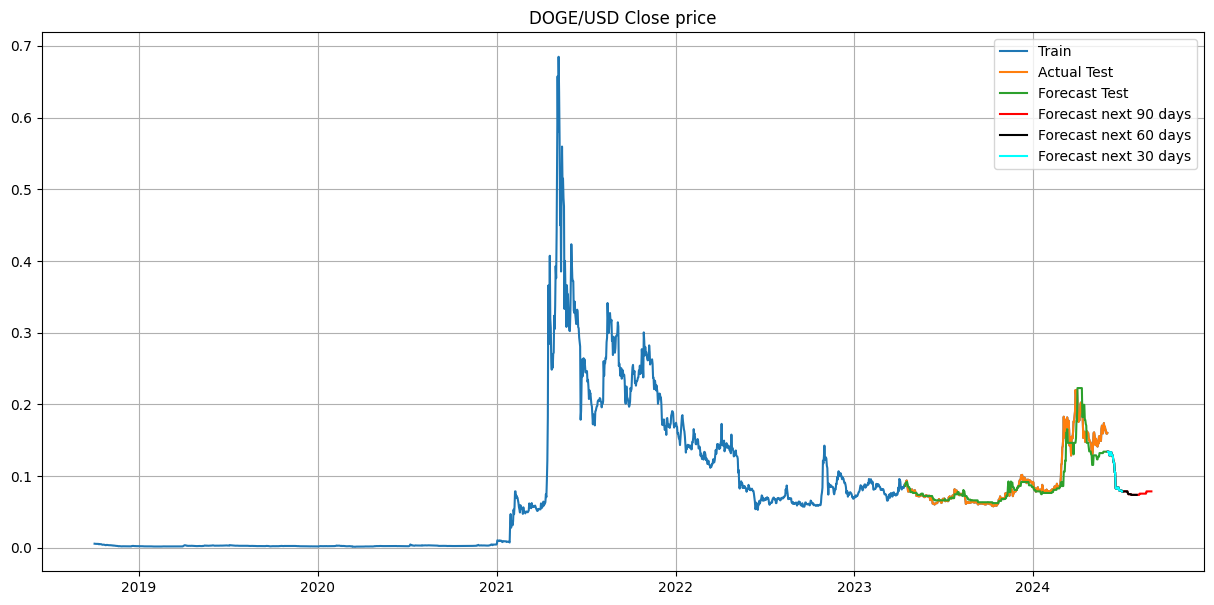

In [11]:
df_forecast_90 = fc_90_day.copy()
df_forecast_90.index = pd.date_range(start=df_filtered.index.max() + dt.timedelta(days=1), periods=len(df_forecast_90))

df_forecast_60 = fc_60_day.copy()
df_forecast_60.index = pd.date_range(start=df_filtered.index.max() + dt.timedelta(days=1), periods=len(df_forecast_60))

df_forecast_30 = fc_30_day.copy()
df_forecast_30.index = pd.date_range(start=df_filtered.index.max() + dt.timedelta(days=1), periods=len(df_forecast_30))


# Plot the overall with connection to forecast
plt.figure(figsize=(15, 7))
plt.plot(df_filtered['Close'], label='Train')
plt.plot(test.index, y_test, label='Actual Test')
plt.plot(test.index, test_preds, label='Forecast Test')
plt.plot(df_forecast_90.index, df_forecast_90['Close'], label='Forecast next 90 days', color='red')
plt.plot(df_forecast_60.index, df_forecast_60['Close'], label='Forecast next 60 days', color='black')
plt.plot(df_forecast_30.index, df_forecast_30['Close'], label='Forecast next 30 days', color='cyan')
plt.title('DOGE/USD Close price')
plt.grid()
plt.legend()
plt.show()

In [12]:
# Calculate the Model's RMSE, MAPE, and SMAPE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    return rmse, mape, smape


# Calculate the metrics for the test data
rmse, mape, smape = calculate_metrics(y_test, test_preds)
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"SMAPE: {smape:.2f}")

RMSE: 0.02
MAPE: 6.95
SMAPE: 7.21
